In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
# 1. Carga de datos
ruta_csv = "/home/adria/Project_break_2_ML/ML_Flights_MAD/src/data_sample/estat_avia_par_es_filtered_en.csv"
df = pd.read_csv(ruta_csv, low_memory=False)
df = df[df['airp_pr'].str.count(" - ") == 1].copy()
df[['Origen', 'Destino']] = df['airp_pr'].str.split(" - ", expand=True)
df['fecha'] = pd.to_datetime(df['TIME_PERIOD'], errors='coerce')
df = df[df['Origen'].str.contains("MADRID", case=False, na=False) |
        df['Destino'].str.contains("MADRID", case=False, na=False)]
df['ruta'] = df['Origen'] + " → " + df['Destino']
df_lstm = df.pivot_table(index='fecha', columns='ruta', values='OBS_VALUE', aggfunc='sum').fillna(0).sort_index()


In [20]:
# 2. Selección de rutas con más de 10 años
df_filtered = df_lstm.loc[:, (df_lstm != 0).sum() > 120]
df_train = df_filtered[df_filtered.index < "2024-01-01"]
df_test = df_filtered[df_filtered.index >= "2024-01-01"]

In [21]:
# 3. Escalado y generación de secuencias
scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns, index=df_train.index)
X, y = df_train_scaled.values, df_train_scaled.values
n_steps = 12

In [22]:
# 4. Definición del modelo base
def create_model(units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(n_steps, X.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(X.shape[1]))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [23]:
# 5. Grid search para optimización de hiperparámetros
param_grid = ParameterGrid({
    'units': [32, 64],
    'dropout_rate': [0.1, 0.2],
    'learning_rate': [0.001],
})

best_loss = float('inf')
best_params = None
best_model = None

for params in param_grid:
    print("Probando configuración:", params)
    model = create_model(**params)
    generator = TimeseriesGenerator(X, y, length=n_steps, batch_size=32)
    history = model.fit(generator, epochs=300, verbose=0)
    final_loss = history.history['loss'][-1]
    if final_loss < best_loss:
        best_loss = final_loss
        best_params = params
        best_model = model

print("Mejores parámetros:", best_params)
best_model.save("/home/adria/Project_break_2_ML/ML_Flights_MAD/src/models/lstm_grid_model.h5")

Probando configuración: {'dropout_rate': 0.1, 'learning_rate': 0.001, 'units': 32}


/home/adria/tf217/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/adria/tf217/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Probando configuración: {'dropout_rate': 0.1, 'learning_rate': 0.001, 'units': 64}
Probando configuración: {'dropout_rate': 0.2, 'learning_rate': 0.001, 'units': 32}
Probando configuración: {'dropout_rate': 0.2, 'learning_rate': 0.001, 'units': 64}


Mejores parámetros: {'dropout_rate': 0.1, 'learning_rate': 0.001, 'units': 64}


In [24]:
# 6. Evaluación y predicción sobre 2024
df_train_scaled_full = pd.DataFrame(scaler.transform(df_filtered[df_filtered.index < "2024-01-01"]),
                                    columns=df_filtered.columns,
                                    index=df_filtered[df_filtered.index < "2024-01-01"].index)
forecast_input = df_train_scaled_full.values[-n_steps:]
future_preds = []

for i in range(12):
    input_batch = forecast_input[-n_steps:].reshape((1, n_steps, df_train_scaled_full.shape[1]))
    pred_scaled = best_model.predict(input_batch, verbose=0)
    forecast_input = np.vstack([forecast_input, pred_scaled])
    future_preds.append(pred_scaled)

future_preds_scaled = np.vstack(future_preds)
future_preds_real = scaler.inverse_transform(future_preds_scaled)
future_dates = pd.date_range(start=df_train.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
df_pred_2024 = pd.DataFrame(future_preds_real, columns=df_filtered.columns, index=future_dates)
df_real_2024 = df_test.loc[future_dates]


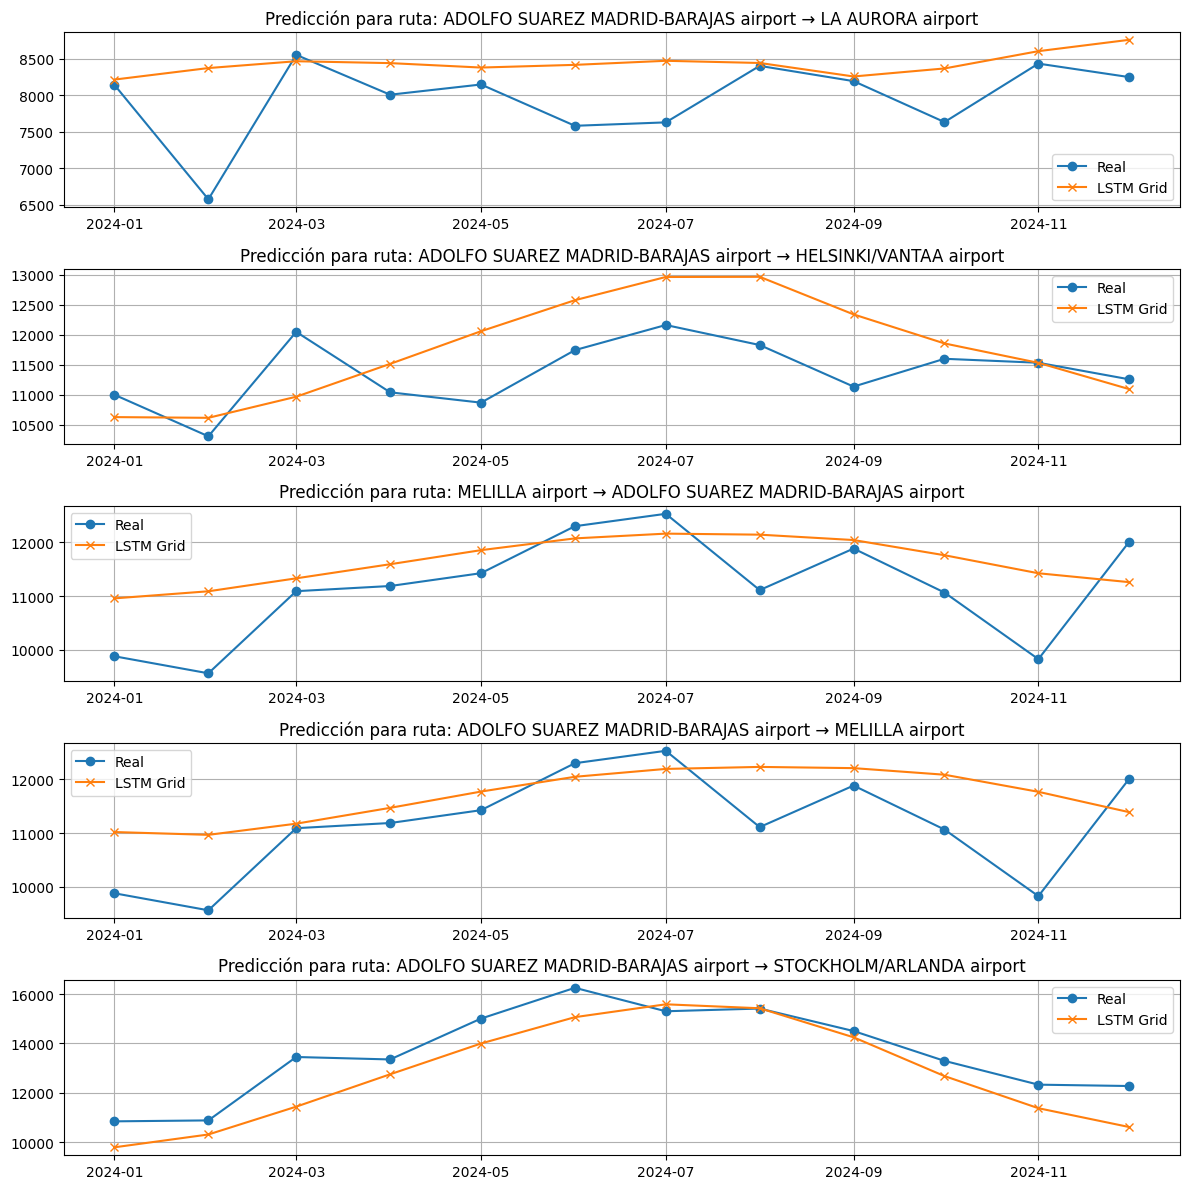

In [25]:
# Errores
errores = []
for ruta in df_pred_2024.columns:
    y_true = df_real_2024[ruta].values
    y_pred = df_pred_2024[ruta].values
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    errores.append({'ruta': ruta, 'MAE': mae, 'RMSE': rmse})
df_errores = pd.DataFrame(errores).sort_values('RMSE')
df_errores.to_csv("/home/adria/Project_break_2_ML/ML_Flights_MAD/src/results/errores_lstm_grid.csv", index=False)

# Gráfico comparativo
top_rutas = df_errores.head(5)['ruta']
plt.figure(figsize=(12, 12))
for i, ruta in enumerate(top_rutas):
    plt.subplot(5, 1, i+1)
    plt.plot(df_real_2024[ruta], label="Real", marker='o')
    plt.plot(df_pred_2024[ruta], label="LSTM Grid", marker='x')
    plt.title(f"Predicción para ruta: {ruta}")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.savefig("/home/adria/Project_break_2_ML/ML_Flights_MAD/src/results/predicciones_lstm_grid_vs_real.png")